## 2.4 Seasonal Plots
A seasonal plot is similar to a time plot except that the data are plotted against the individual “seasons” in which the data were observed.

In [1]:
import pandas as pd
from plotnine import ggplot, aes, geom_line, labs
from plotnine import scale_x_datetime
from plotnine import scale_x_continuous, geom_text, theme, scale_color_discrete
from mizani.formatters import date_format

### Antidiabetic drug sales

In [3]:
PBS = pd.read_csv('../data/tsibbledata/PBS.csv')

PBS['Date'] = pd.to_datetime(PBS['Month'], format='%Y %b')
PBS['Month'] = PBS['Date'].dt.strftime('%b')
PBS['month_number'] = PBS['Date'].dt.month
PBS['Year'] = PBS['Date'].dt.year.astype(str)

In [4]:
a10_seasonal = (
    PBS.query('ATC2 == "A10"')  # Filter rows where ATC2 is "A10"
    .groupby('Date', as_index=False)  # Group by Month
    .agg({'Cost': 'sum', 'Year': 'first', 'Month': 'first', 'month_number': 'first'})  # Summarize total cost by month
    .assign(Cost=lambda df: df['Cost'] / 1e6)  # Convert cost to millions
    .sort_values(by=['Year', 'month_number'])
)

In [5]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

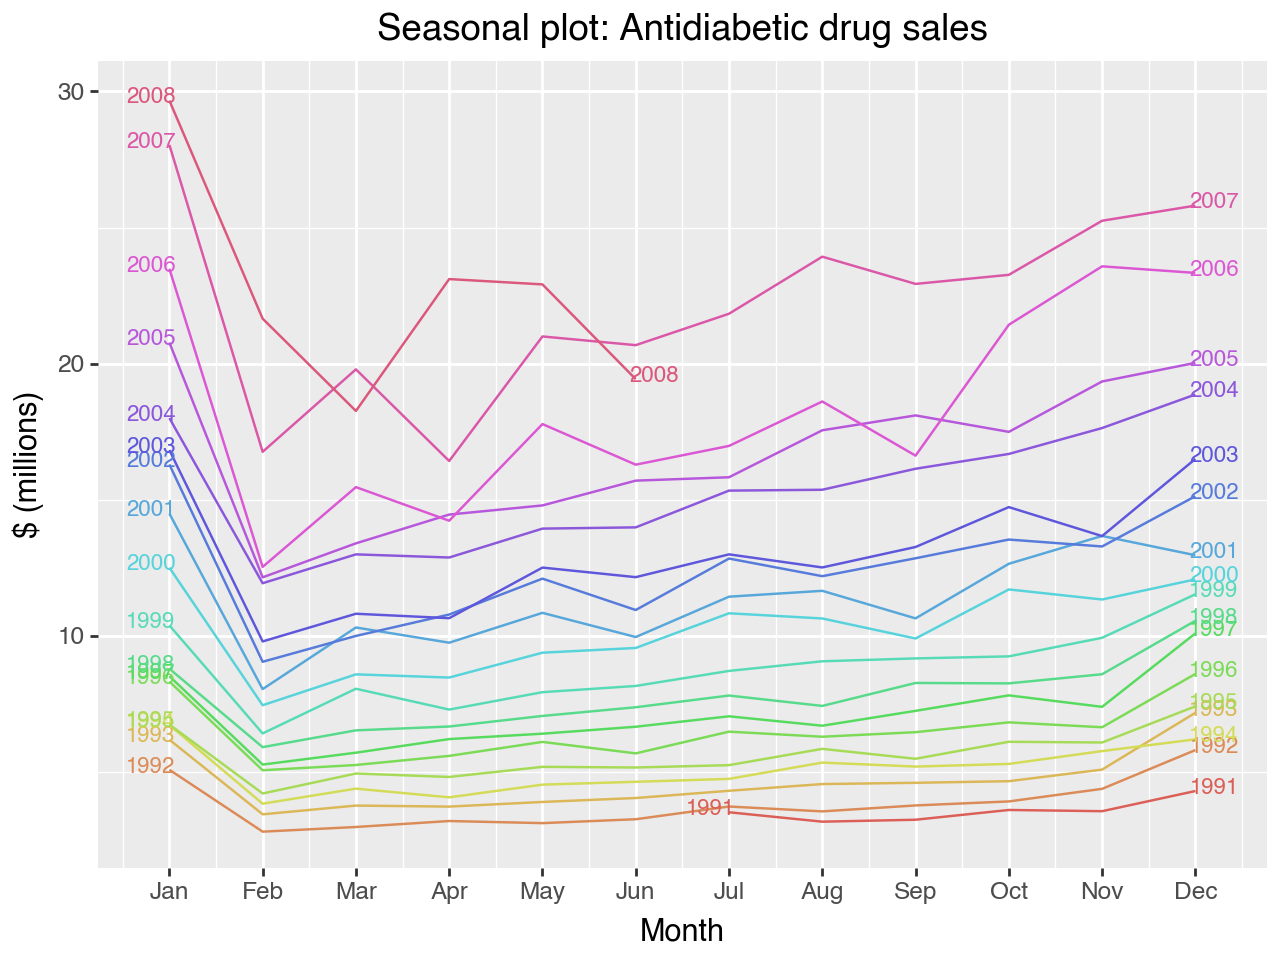

In [6]:
ggplot(a10_seasonal) \
    + aes(x="month_number", y='Cost', color='Year', group="Year") \
    + geom_line() \
    + geom_text(aes(label='Year'), 
                data=a10_seasonal.groupby('Year').last().reset_index(), 
                nudge_y=0.1, 
                nudge_x=0.2,
                size=8) \
    + geom_text(aes(label='Year'), 
                data=a10_seasonal.groupby('Year').first().reset_index(), 
                nudge_y=0.1, 
                nudge_x=-0.2,
                size=8) \
    + scale_x_continuous(breaks=range(1, 13), labels=months) \
    + labs(x='Month', y = "$ (millions)",
       title = "Seasonal plot: Antidiabetic drug sales") \
    + theme(legend_position='none') \
        + scale_color_discrete()

### Multiple Seasonal Periods
Electricity demand in Victoria

In [11]:
vic_elec = (pd.read_csv('../data/tsibbledata/vic_elec.csv')
 .assign(Time=lambda df: pd.to_datetime(df['Time']))
 .set_index('Time')
 ) 

In [9]:
import sys
sys.path.append('../')
from utils import summarize

In [54]:
def seasonalize(data, column, period='year'):
    if period.lower() in ('year', 'y'):
        d = data.assign(
            __period = data.index.year,
            __x = data.index.dayofyear)
    elif period.lower() in ('week', 'w'):
        d = data.assign(
            __period = 100*data.index.year + data.index.isocalendar().week,
            __x = data.index.dayofweek
                + (data.index.hour + data.index.minute/60 + data.index.second/3600) / 24)
    elif period.lower() in ('day', 'd'):
        d = data.assign(
            __period = data.index.date,
            __x = data.index.hour + data.index.minute/60 + data.index.second/3600)
    d = (
        d
        .sort_values('__x')
        .groupby('__period')
        .pipe(summarize, lambda x: {'time': list(x.__x), column: list(x[column])})
    )
    return d

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.0)

In [26]:
def plot_seasonal(
        data, column,
        period='year',
        cmap='viridis',
        labels='',
        figsize=None,
        ax=None,
        **kw):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig, ax = ax.figure, ax
    d = seasonalize(data, column, period)
    cm = plt.get_cmap(cmap)
    for (i, p) in enumerate(d.index):
        color = cm(i / len(d))
        x, y = d.time.loc[p], d[column].loc[p]
        ax.plot(x, y, color=color, label=str(p), **kw)
        if labels in 'right both'.split():
            ax.text(x[-1], y[-1], str(p), color=color, ha='center', va='center')
        if labels in 'left both'.split():
            ax.text(x[0], y[0], str(p), color=color, ha='center', va='center')
    return ax

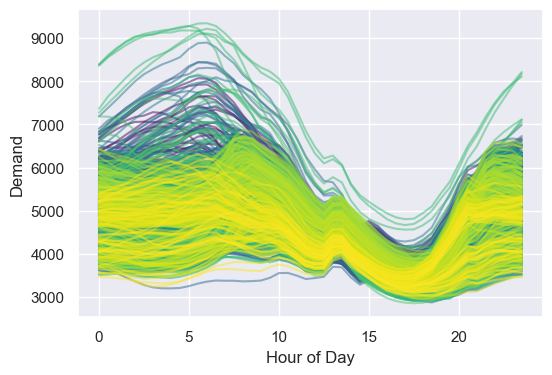

In [45]:
ax = plot_seasonal(vic_elec, 'Demand', period='d', alpha=.5, figsize=(6, 4))
ax.set(xlabel='Hour of Day', ylabel='Demand')
#ax.grid()
plt.show()

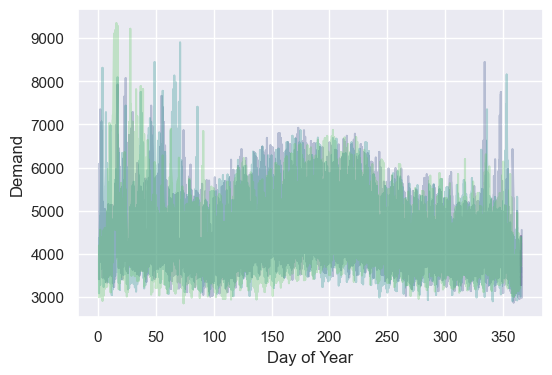

In [57]:
ax = plot_seasonal(vic_elec, 'Demand', period='y', alpha=.3, figsize=(6, 4))
ax.set(xlabel='Day of Year', ylabel='Demand')
plt.show()

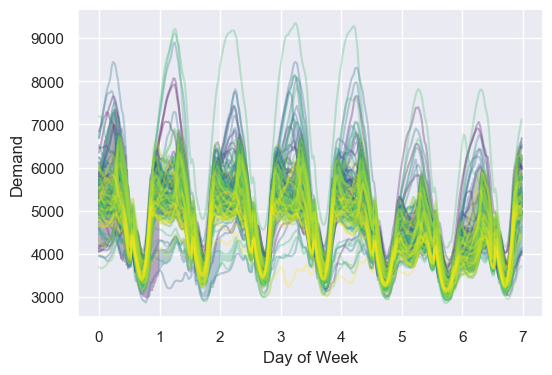

In [56]:
ax = plot_seasonal(vic_elec, 'Demand', period='w', alpha=.3, figsize=(6, 4))
ax.set(xlabel='Day of Week', ylabel='Demand')
plt.show()